In [45]:
import pandas as pd

# Plots with high resolution
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150
import matplotlib.pyplot as plt

# Benchmark Results and Evaluation

## Configuration
* Taurus Haswell Partition (in particular TAURUSI6596)
* Modules:
   * superlu/5.2.1
   * intelmpi/2017.2.174
   * superlu_dist/5.1.3
   * superlu_mt/3.1
   * intel/2017.2.174
* --exclusive
* No thread pinning, because ...
    * it should not make a big differance in results
    * end-users don't use it



**Weiter**
    * Auswertung der restlichen Daten
    * Diese müssen in einzelne CSV-Datein gepresst werden
    * Findings aufschreiben
    
**Todo**    
    * Auflösung der Plots verbessern

## Result Analysis

Some remarks
* All runs where repeated R times (e.g., R=11)
* Since the first run is in most cases way slower than the other runs, we ignore the first run
* This is also called "warm startup", beacuse the data structures are allready in memory hierarchies

Directory structure holding the csv files with the benchmark statistics.

In [46]:
dir_60F="taurus_haswell/hqp3_60/Full"
dir_15F="taurus_haswell/hqp3_15/Full"
dir_60S="taurus_haswell/hqp3_60/Sp"
dir_15S="taurus_haswell/hqp3_15/Sp"

### hqp3_60_Full

#### SuperLU

Read in the benchmark results for **SuperLU** and the various orderings.

In [47]:
slu_col = pd.read_csv(dir_60F+'/hqp3_60_Full_SuperLU_COLAMD.csv',skipinitialspace=True)

In [48]:
slu_nat = pd.read_csv(dir_60F+'/hqp3_60_Full_SuperLU_NATURAL.csv',skipinitialspace=True)

In [49]:
slu_ata = pd.read_csv(dir_60F+'/hqp3_60_Full_SuperLU_MMD_ATA.csv',skipinitialspace=True)

In [50]:
slu_usa = pd.read_csv(dir_60F+'/hqp3_60_Full_SuperLU_MMD_AT_PLUS_A.csv',skipinitialspace=True)

In [51]:
slu_col.head()

,#Iter,info,#NNZ in L,#NNZ in U,LU MB,Total MB,Norm,RPG,RCN,dgssvx
0,0,0,495102,706458,12.966,24.253,9.549530e-09,0.212632,3.707492e-07,287225
1,1,0,495102,706458,12.966,24.253,9.549530e-09,0.212632,3.707492e-07,213849
2,2,0,495102,706458,12.966,24.253,9.549530e-09,0.212632,3.707492e-07,210737
3,3,0,495102,706458,12.966,24.253,9.549530e-09,0.212632,3.707492e-07,222330
4,4,0,495102,706458,12.966,24.253,9.549530e-09,0.212632,3.707492e-07,222801


In [52]:
slu_col['dgssvx']

0     287225
1     213849
2     210737
3     222330
4     222801
5     220973
6     221494
7     222087
8     211041
9     209310
10    209356
Name: dgssvx, dtype: int64

In [53]:
slu_col.describe(include='all')

,#Iter,info,#NNZ in L,#NNZ in U,LU MB,Total MB,Norm,RPG,RCN,dgssvx
count,11.000000,11.0,11.0,11.0,1.100000e+01,1.100000e+01,1.100000e+01,1.100000e+01,1.100000e+01,11.000000
mean,5.000000,0.0,495102.0,706458.0,1.296600e+01,2.425300e+01,9.549530e-09,2.126318e-01,3.707492e-07,222836.636364
std,3.316625,0.0,0.0,0.0,1.863059e-15,3.726118e-15,1.735109e-24,2.911029e-17,5.552348e-23,22097.444157
min,0.000000,0.0,495102.0,706458.0,1.296600e+01,2.425300e+01,9.549530e-09,2.126318e-01,3.707492e-07,209310.000000
25%,2.500000,0.0,495102.0,706458.0,1.296600e+01,2.425300e+01,9.549530e-09,2.126318e-01,3.707492e-07,210889.000000
50%,5.000000,0.0,495102.0,706458.0,1.296600e+01,2.425300e+01,9.549530e-09,2.126318e-01,3.707492e-07,220973.000000
75%,7.500000,0.0,495102.0,706458.0,1.296600e+01,2.425300e+01,9.549530e-09,2.126318e-01,3.707492e-07,222208.500000
max,10.000000,0.0,495102.0,706458.0,1.296600e+01,2.425300e+01,9.549530e-09,2.126318e-01,3.707492e-07,287225.000000


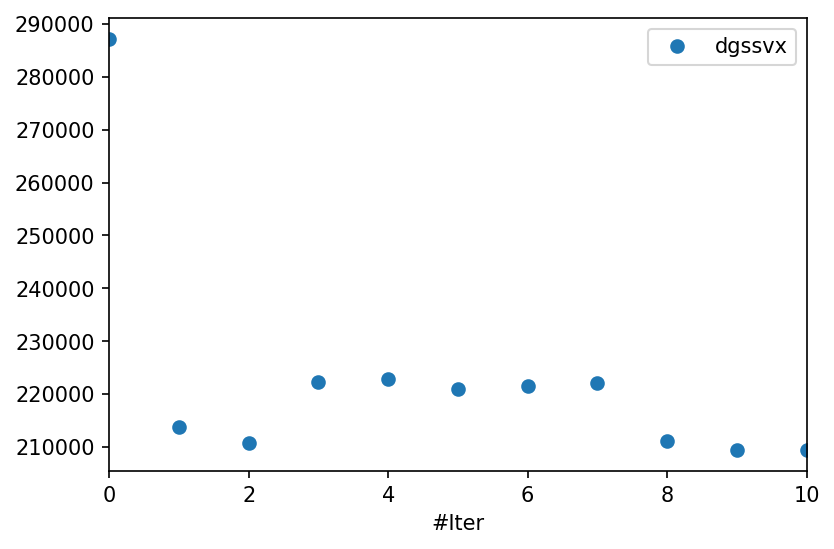

In [54]:
slu_col.plot(x='#Iter', y='dgssvx', style='o')
plt.show()

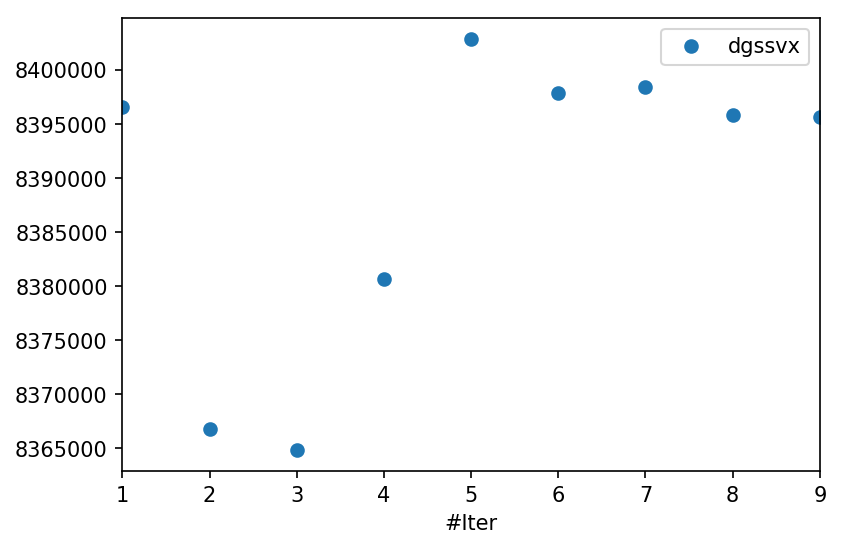

In [55]:
# Okay, here come two ways to plot the timings
# 
# 1. Way:
#    But how to divide values by 1000 to get timings in [ms]?
slu_nat[1:10].plot(x='#Iter', y='dgssvx', style='o')
plt.show()

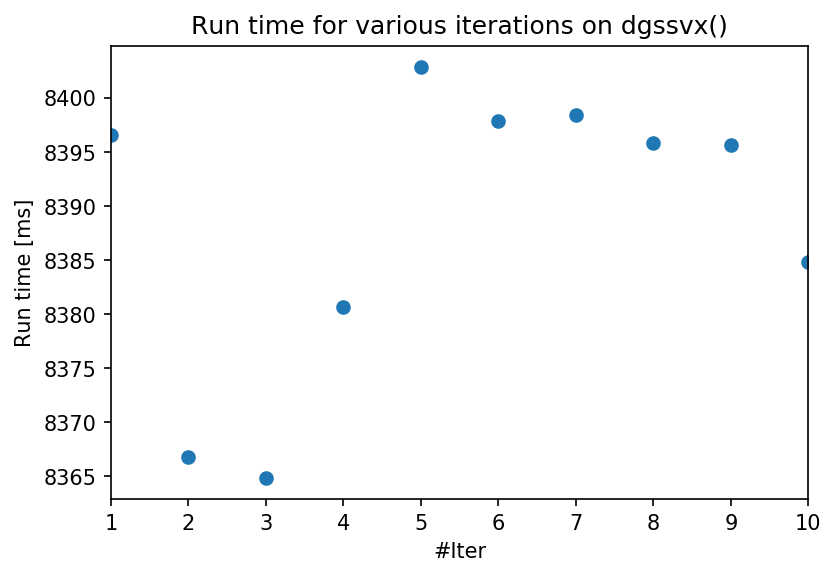

In [56]:
# 2. Way:
a = (slu_nat['dgssvx'])[1:11]/1000
ax = a.plot(style='o',title='Run time for various iterations on dgssvx()')
ax.set(xlabel="#Iter", ylabel="Run time [ms]")
plt.show()

---

Let's gather the statistical values for the obtained timings (in ms).

In [57]:
# Lower and upper index bound.
# Since we have 11 runs, we omit the results from the very first.
l=1
u=11

In [58]:
slu_nat_tstats = [(slu_nat['dgssvx'])[l:u].mean()/1000,
                  (slu_nat['dgssvx'])[l:u].max()/1000,
                  (slu_nat['dgssvx'])[l:u].min()/1000,
                  (slu_nat['dgssvx'])[l:u].std()/1000 ]
slu_col_tstats = [(slu_col['dgssvx'])[l:u].mean()/1000,
                  (slu_col['dgssvx'])[l:u].max()/1000,
                  (slu_col['dgssvx'])[l:u].min()/1000,
                  (slu_col['dgssvx'])[l:u].std()/1000 ]
slu_ata_tstats = [(slu_ata['dgssvx'])[l:u].mean()/1000,
                  (slu_ata['dgssvx'])[l:u].max()/1000,
                  (slu_ata['dgssvx'])[l:u].min()/1000,
                  (slu_ata['dgssvx'])[l:u].std()/1000 ]
slu_usa_tstats = [(slu_usa['dgssvx'])[l:u].mean()/1000,
                  (slu_usa['dgssvx'])[l:u].max()/1000,
                  (slu_usa['dgssvx'])[l:u].min()/1000,
                  (slu_usa['dgssvx'])[l:u].std()/1000 ]

In [59]:
ind = ['Mean', 'Max', 'Min', 'Std']
d = {'NATURAL': slu_nat_tstats,
     'COLAMD' : slu_col_tstats,
     'MMD_ATA' : slu_ata_tstats,
     'MMD_AT_PLUS_A' : slu_usa_tstats
    }
df = pd.DataFrame(data=d, index=ind)
df = df[['COLAMD', 'NATURAL', 'MMD_ATA', 'MMD_AT_PLUS_A']] # Order columns in my way (not alphabetically)
df

,COLAMD,NATURAL,MMD_ATA,MMD_AT_PLUS_A
Mean,216.397800,8388.44270,294.692600,747.133100
Max,222.000000,8402.00000,297.000000,750.000000
Min,209.000000,8364.00000,291.000000,740.000000
Std,5.986307,13.64961,1.980908,2.766541


In [60]:
slu_best_time = min(slu_col_tstats[0],slu_nat_tstats[0],slu_ata_tstats[0],slu_usa_tstats[0])
print("Best serial time [ms]: ", slu_best_time)

('Best serial time [ms]: ', 216.3978)


What about memory consumption (in MB)?

In [61]:
slu_nat_mstats = [(slu_nat['Total MB'])[l:u].mean(),
                  (slu_nat['LU MB'])[l:u].mean()    ]
slu_col_mstats = [(slu_col['Total MB'])[l:u].mean(),
                  (slu_col['LU MB'])[l:u].mean()    ]
slu_ata_mstats = [(slu_ata['Total MB'])[l:u].mean(),
                  (slu_ata['LU MB'])[l:u].mean()    ]
slu_usa_mstats = [(slu_usa['Total MB'])[l:u].mean(),
                  (slu_usa['LU MB'])[l:u].mean()    ]

In [62]:
ind = ['Total', 'L\U']
d = {'NATURAL': slu_nat_mstats,
     'COLAMD' : slu_col_mstats,
     'MMD_ATA' : slu_ata_mstats,
     'MMD_AT_PLUS_A' : slu_usa_mstats
    }
df = pd.DataFrame(data=d, index=ind)
df = df[['COLAMD', 'NATURAL', 'MMD_ATA', 'MMD_AT_PLUS_A']] # Order columns in my way (not alphabetically)
df

,COLAMD,NATURAL,MMD_ATA,MMD_AT_PLUS_A
Total,24.253,254.671,21.728,36.507
L\U,12.966,243.384,10.441,25.219


**Findings:**
* COLAMD, which is the default option, yields the fastest timings with reasonable small memory footprint
* MMD_ATA is a bit off with respect to timing and has a little bit smaller memory footprint compared to COLAMD
* NATURAL is off in both statistics
* MMD_AT_PLUS_A is way off in timing, but reasonable in memory footprint

---

#### SuperLU_MT

In [112]:
def get_tstats(df, spec, runs=11):
    """"Compute timing statistics for a data_frame.
        Omit first run for every thread.
        Assume the runs for a fixed number of threads are seperated by empty line from each other.
        Assume also consecutive scaling of threads (see for loop).

    Args:
        df (pandas.dataFrame): 
        spec (str): Column specifier
        runs (int, optional): Number of runs for a fixed number of threads.

    Returns:
        List of speedups.
    """
    ret = []
    threads = []
    l = 1;
    u = l+runs-1
    for i in range(int(df['#Threads'].min()), int(df['#Threads'].max())+1):
        threads.append(i)
        mean = df[spec][l:u].mean()
        mini = df[spec][l:u].min()
        maxi = df[spec][l:u].max()
        std = df[spec][l:u].std()
        ret.append([mean, mini, maxi, std])
        # Update l and u
        # print(l, ", ", u)
        l += runs+1
        u = l+runs-1
        
    return threads,ret

Read in the csv files holding the statistics.

In [113]:
slumt_col = pd.read_csv(dir_60F+'/hqp3_60_Full_SuperLU_MT_COLAMD.csv',skipinitialspace=True)
#slumt_nat = pd.read_csv('hqp3_60_Full_SuperLU_MT_NATURAL.csv',skipinitialspace=True)
slumt_ata = pd.read_csv(dir_60F+'/hqp3_60_Full_SuperLU_MT_MMD_ATA.csv',skipinitialspace=True)
slumt_usa = pd.read_csv(dir_60F+'/hqp3_60_Full_SuperLU_MT_MMD_AT_PLUS_A.csv',skipinitialspace=True)

Okay, we want the timings in ms.

In [114]:
slumt_col['pdgssvx'] = slumt_col['pdgssvx'] / 1000
slumt_ata['pdgssvx'] = slumt_ata['pdgssvx'] / 1000
slumt_usa['pdgssvx'] = slumt_usa['pdgssvx'] / 1000

In [110]:
(211.785+211.375+212.390+211.459
+212.526+212.437+212.180+212.405+212.439+212.663)/10


212.16590000000005

Gather timing statistics for SuperLU_MT: mean, std, min and max.

In [115]:
(threads,slumt_col_tstats) = get_tstats(slumt_col, 'pdgssvx', 11)
(threads,slumt_ata_tstats) = get_tstats(slumt_ata, 'pdgssvx', 11)
(threads,slumt_usa_tstats) = get_tstats(slumt_usa, 'pdgssvx', 11)

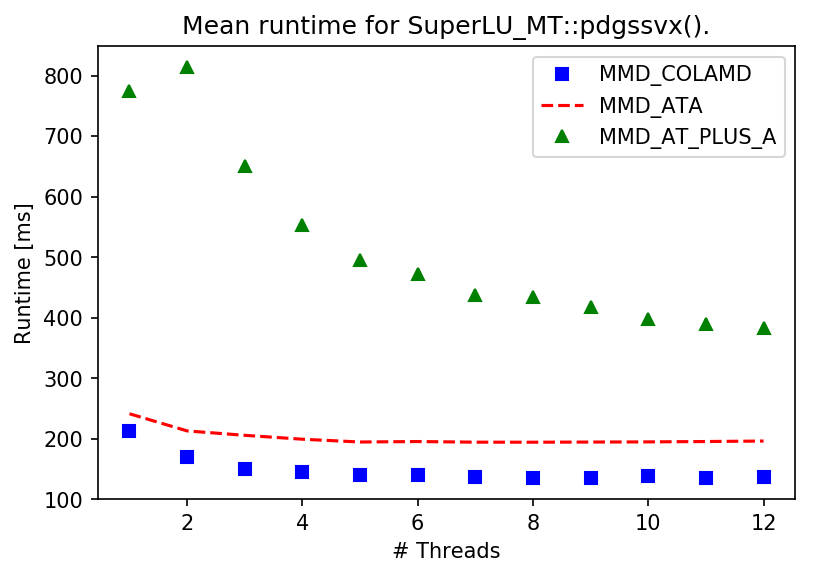

In [116]:
# All first items in slumt_col_tstats of type list(list)
#lst = [item[0] for item in slumt_col_tstats]
plt.plot(threads, [item[0] for item in slumt_col_tstats], 'bs', label="MMD_COLAMD" )
plt.plot(threads, [item[0] for item in slumt_ata_tstats], 'r--', label="MMD_ATA" )
plt.plot(threads, [item[0] for item in slumt_usa_tstats], 'g^', label="MMD_AT_PLUS_A" )
plt.ylabel('Runtime [ms]')
plt.xlabel('# Threads')
legend = plt.legend(loc='best')
plt.title('Mean runtime for SuperLU_MT::pdgssvx().')
plt.show()

Have a look at the speedups for the various orderings.

In [102]:
def get_speedups(tstats, t1=None):
    """"Return speedups for a given list of timing statistics (mean time over #threads).

    Args:
        tstats (list): Timing statistics
        t1 (float, optional): Serial time to refer the speedup to. If not given, we use the runtime using 1 thread.

    Returns:
        List of speedups.
    """
    sp = []
    if t1 is None:
        t1 = tstats[0][0] # Time for serial run
    # Todo: Check that provided t1 is a numerical value > 0.
    for i in [item[0] for item in tstats]:
        #print(i)
        sp.append(t1/i)
    
    return sp

In [103]:
%%time
sp_col = get_speedups(slumt_col_tstats, slu_best_time)
sp_ata = get_speedups(slumt_ata_tstats, slu_best_time)
sp_usa = get_speedups(slumt_usa_tstats, slu_best_time)

CPU times: user 44 µs, sys: 3 µs, total: 47 µs
Wall time: 37.9 µs


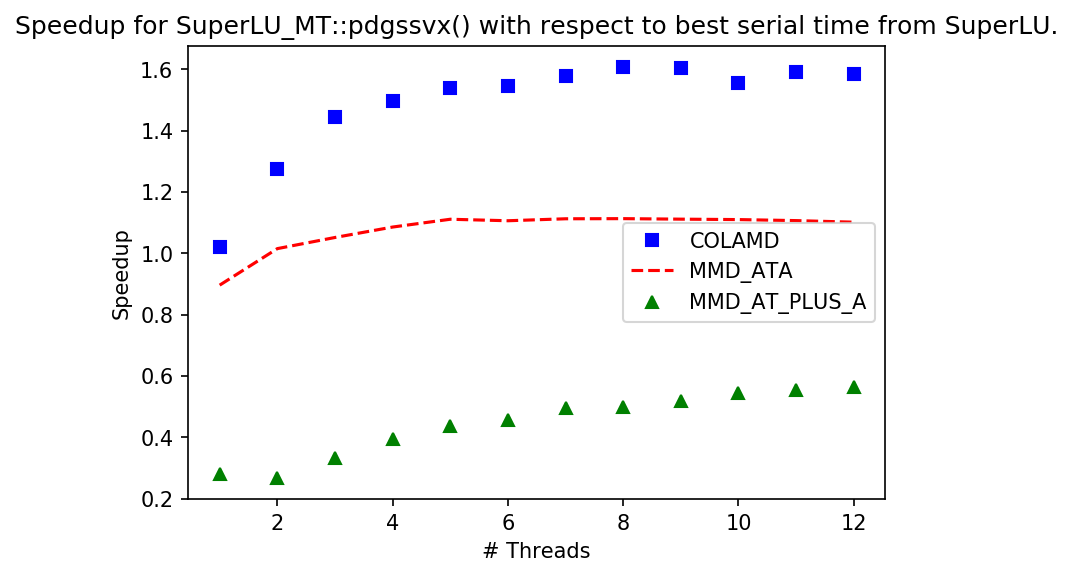

In [104]:
plt.plot(threads, sp_col, 'bs', label="COLAMD")
plt.plot(threads, sp_ata, 'r--', label="MMD_ATA")
plt.plot(threads, sp_usa, 'g^', label="MMD_AT_PLUS_A")
plt.ylabel('Speedup')
plt.xlabel('# Threads')
legend = plt.legend(loc='best')
plt.title('Speedup for SuperLU_MT::pdgssvx() with respect to best serial time from SuperLU.')
plt.show()

Have a look at the total memory consumption for SuperLU_MT. Remark: The memory consumption for the L\U decomposition can be plotted the very same way. Since it scales linear with the number of threads, too, we do not plot it. 

In [117]:
(_, slumt_col_mstats) = get_tstats(slumt_col, 'Total MB', 11)
(_, slumt_ata_mstats) = get_tstats(slumt_ata, 'Total MB', 11)
(_, slumt_usa_mstats) = get_tstats(slumt_usa, 'Total MB', 11)

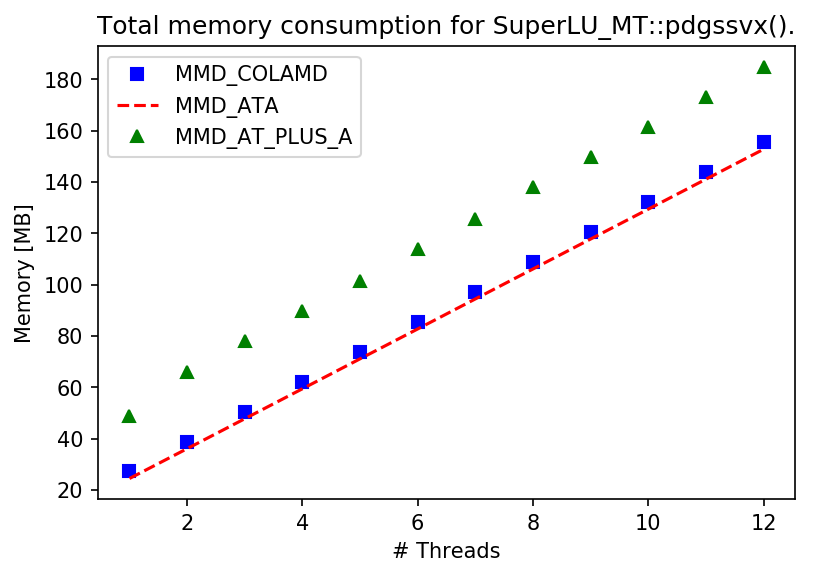

In [106]:
# All first items in slumt_col_tstats of type list(list)
#lst = [item[0] for item in slumt_col_tstats]
plt.plot(threads, [item[0] for item in slumt_col_mstats], 'bs', label="MMD_COLAMD" )
plt.plot(threads, [item[0] for item in slumt_ata_mstats], 'r--', label="MMD_ATA" )
plt.plot(threads, [item[0] for item in slumt_usa_mstats], 'g^', label="MMD_AT_PLUS_A" )
plt.ylabel('Memory [MB]')
plt.xlabel('# Threads')
legend = plt.legend(loc='best')
plt.title('Total memory consumption for SuperLU_MT::pdgssvx().')
plt.show()

In [162]:
from operator import itemgetter
def get_best_time(list1, list2, list3):
    """
        Return min. value and the coresponding index over three lists.
        Todo: Pass arbitrary number of lists.... or list(list, list, ...,list)
        This is a very stupid implementation I have to admit.
    """
    # Create list containing (idx1, min_val1), (idx2, min_val2), ...
    # Than determine min value and the corresponding index. Than return the corresponding sublist.
    l = []
    l.append(min(enumerate(map(itemgetter(0), list1)), key=itemgetter(1)))
    l.append(min(enumerate(map(itemgetter(0), list2)), key=itemgetter(1)))
    l.append(min(enumerate(map(itemgetter(0), list3)), key=itemgetter(1)))
    i, j = min(enumerate(map(itemgetter(1), l)), key=itemgetter(1))
    return l[i]
    

In [163]:
(th, slumt_best_time) = get_best_time(slumt_col_tstats, slumt_ata_tstats, slumt_usa_tstats)

print("Best SuperLU time [ms]:    ", slu_best_time)
print("Best SuperLU_MT time [ms]: ", slumt_best_time, " using %s threads" % th)

('Best SuperLU time [ms]:    ', 216.3978)
('Best SuperLU_MT time [ms]: ', 134.47570000000002, ' using 7 threads')


**Findings:**
* COLAMD yields the fastest timings to solve the system
  * It scales very reasonable up to 8 threads
* Memory consumption scales linear with the number of threads. This holds for all ordering algorithms.
  * MMD_AT_PLUS_A requests a (constant) additional amount of memory compared to COLAMD and MMD_ATA
* SuperLU_MT yields nearly a **speedup of factor 2** with respect to SuperLU!

# TODO
* Box plots oder violin plots für SLUMT
* Dist auswerten

----

# SuperLU_DIST

Yeah, this will take some time since we have a additional dimension due to 2d process grid

In [74]:
sludist_ata = pd.read_csv(dir_60F+'/hqp3_60_Full_SuperLU_DIST_MMD_ATA.csv',skipinitialspace=True)

In [75]:
def condense_df(df, runs=5):
    """"Condense DataFrame in the sense, that it holds the mean run time for a process grid, not the several individual run times.
        Omit first run for every process grid configuration.
        Assume no empty lines between blocks of fixed grid size.

    Args:
        df (pandas.dataFrame): 
        runs (int, optional): Number of runs for a fixed number of threads.

    Returns:
        DataFrame with mean timings in ms.
    """
    rows = []
    l = 1;
    u = l+runs-1
    for i in range(0,df.shape[0]/runs):
        rows.append((df['#MPI Procs'][l], df['nrow'][l], df['ncol'][l], df['pdgssvx_Abglobal'][l:u].mean()/1000))
        # Update l and u
        #print("l ", l, " u ", u)
        l += runs
        u = l+runs-1
        
    cols = ['#MPI Procs', 'nrows', 'ncols', 'time']
    return pd.DataFrame.from_records(rows, columns=cols)

In [76]:
dfc = condense_df(sludist_ata, 5)

**Todo** Different 2d grids result in the very same number of MPI procesess, like 2x3 and 3x2. Mark this in the following plot

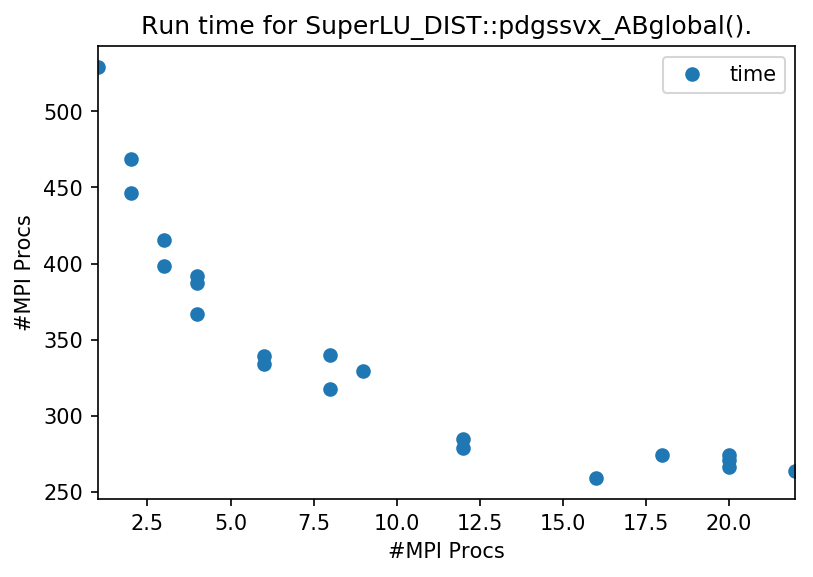

In [77]:
dfc.plot(x='#MPI Procs', y='time', style='o')
plt.ylabel('Run time [ms]')
plt.ylabel('#MPI Procs')
legend = plt.legend(loc='best')
plt.title('Run time for SuperLU_DIST::pdgssvx_ABglobal().')
#ax.set(xlabel="#Iter", ylabel="Ruasn time [ms]")
plt.show()

In [78]:
best_

NameError: name 'best_' is not defined

----

Zwischenablage- brauchen wir das noch?

Boxplot of the timings for ordering COLAMD over all threads. This plot is not very usefull, is it?
It ca be seen some kind of scaling (but for this a plot of the speedup would be better) and that the variance of the inividual runs is very small.

In [ ]:
ax = sns.boxplot(x="#Threads", y="pdgssvx", data=slumt_col, showfliers=False)
sns.plt.show()

Boxplot for ordering COLAMD and 1 thread. Just as example.

In [ ]:
xx=slumt_col[1:11]
ax = sns.boxplot(x="#Threads", y="pdgssvx", data=xx)
sns.plt.show()

In [ ]:
#Boxplots https://matplotlib.org/examples/pylab_examples/boxplot_demo.html
spread = np.random.rand(50) * 100
center = np.ones(25) * 50
flier_high = np.random.rand(10) * 100 + 100
flier_low = np.random.rand(10) * -100
data = np.concatenate((spread, center, flier_high, flier_low), 0)
type(data)
# basic plot
#plt.boxplot(data)
#plt.show()

In [ ]:
# Since we have a scaled number of threads, we are only interested in mean timing in the first step
ind = range(1, 13)
d = {'Mean' : list(zip(*slumt_col_tstats))[0],
    # 'MMD_ATA' : slu_ata_tstats,
    # 'MMD_AT_PLUS_A' : slu_usa_tstats
    }
df = pd.DataFrame(data=d, index=ind)
#df = df[['COLAMD', 'MMD_ATA', 'MMD_AT_PLUS_A']] # Order columns in my way (not alphabetically)
df
